# CIFAR-10 이미지 생성하기

In [71]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams

print("tensorflow", tf.__version__)

tensorflow 2.6.0


## 데이터셋 구성하기

In [23]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [24]:
#max값과 min값 출력
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [25]:
#학습에 사용할 train_x 이미지를 -1에서 1사이 값으로 정규화
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [26]:
train_x.shape

(50000, 32, 32, 3)

In [27]:
#이미지 데이터 shape 32,32,3
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

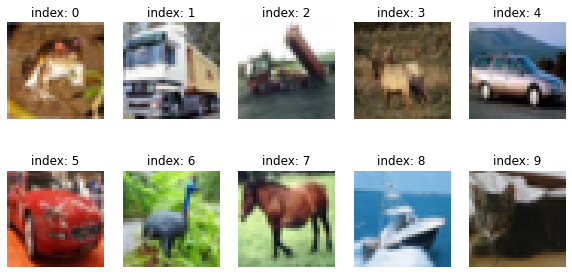

In [30]:
plt.figure(figsize=(10, 5))

for i in range(10):  #10개 이미지 확인
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i] + 1) / 2.0)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [31]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [32]:
#tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋 구성
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 생성자 모델 구현하기
DCGAN(Deep Convolutional GAN) 모델 구현하기.

In [54]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [55]:
generator = make_generator_model() #generator변수로 생성모델 생성

generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 8, 128)        

In [56]:
#랜덤 노이즈를 입력하여 방금 구현한 생성자로 랜덤 이미지를 생성
noise = tf.random.normal([1, 100])

In [57]:
generated_image = generator(noise, training=False)  #가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 생성
generated_image.shape

TensorShape([1, 32, 32, 3])

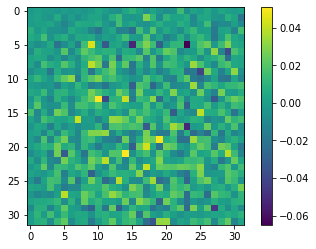

In [58]:
#시각화
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## 판별자 모델 구현하기

In [59]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [60]:
discriminator = make_discriminator_model()  #discriminator 변수로 판별모델 생성

discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)             

In [61]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00123436]], dtype=float32)>

##  손실함수와 최적화 함수 구현하기

In [62]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [63]:
#real_output:기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)
#fake_output:생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)

#generator_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) 

In [64]:
#discriminator_loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [65]:
#discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [66]:
#최적화 함수(optimizer)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)  #Adam 최적화 기법 활용
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [67]:
noise_dim = 100
num_examples_to_generate = 16  # 생성자가 생성한 샘플 16개

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 훈련과정 상세 기능 구현하기

In [68]:
@tf.function  #이 데코레이터는 우리가 직접 session을 열어서 학습했다가, 학습이 완료되면 다시 닫아주는 등의 번거로운 과정을 내부적으로 처리해서 더욱 편리하게 학습시킬 수 있게 해준다.
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [72]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [79]:
#정기적으로 모델을 저장하기 위한 checkpoint
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 학습 과정 진행하기

In [74]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)  #지금까지 한 단계를 학습
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)  # 샘플 이미지를 생성하고 저장
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)  # 모델 저장

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)  # 학습 과정을 시각화

In [75]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

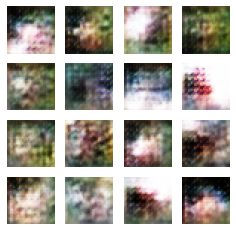

Time for training : 735 sec


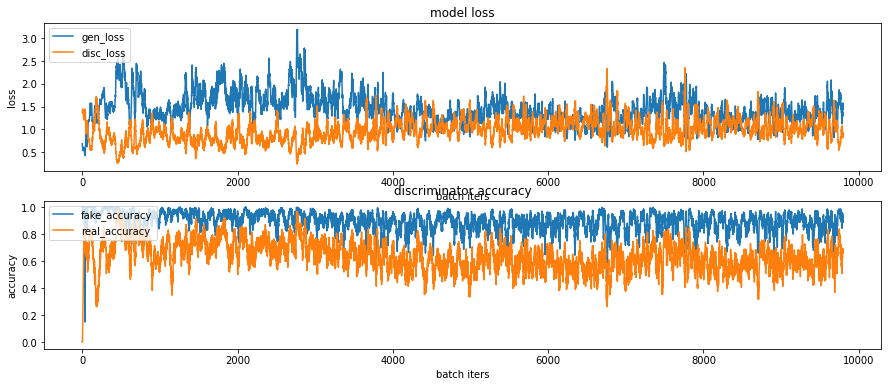

CPU times: user 12min 46s, sys: 1min 4s, total: 13min 51s
Wall time: 12min 16s


In [76]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [77]:
#학습과정 시각화하기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1034187 Feb 14 06:52 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


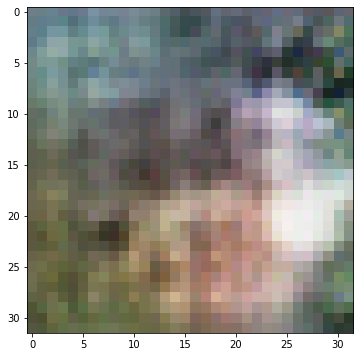

In [80]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## (optional) GAN 훈련 과정 개선하기  
#### (1) EPOCHS = 200

In [81]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [83]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

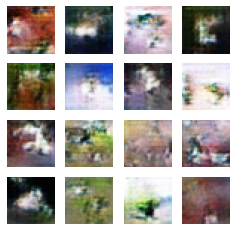

Time for training : 3066 sec


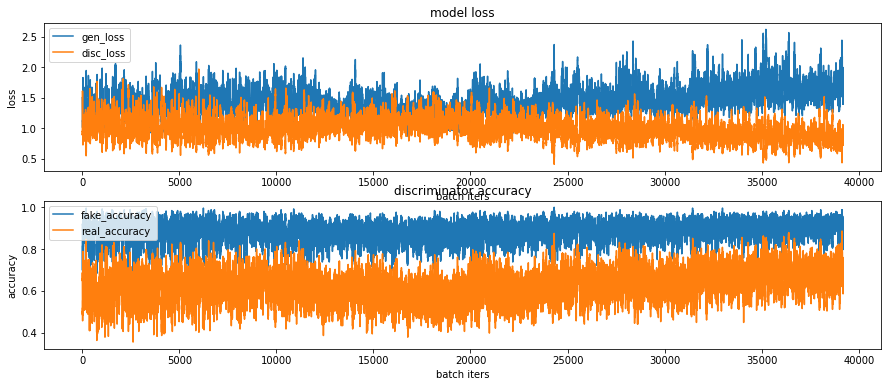

CPU times: user 53min 17s, sys: 4min 23s, total: 57min 41s
Wall time: 51min 8s


In [84]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [94]:
#시각화
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_2.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1034187 Feb 14 06:52 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


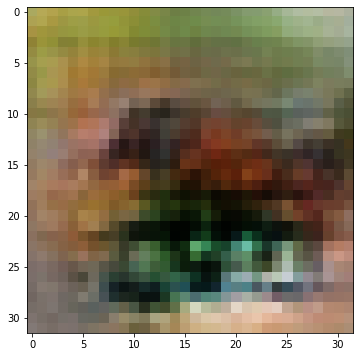

In [86]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

#### (2) EPOCHS = 1000

In [89]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [90]:
save_every = 5
EPOCHS = 1000

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

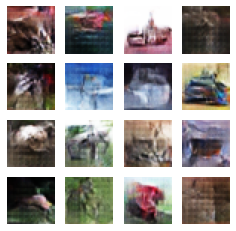

Time for training : 18710 sec


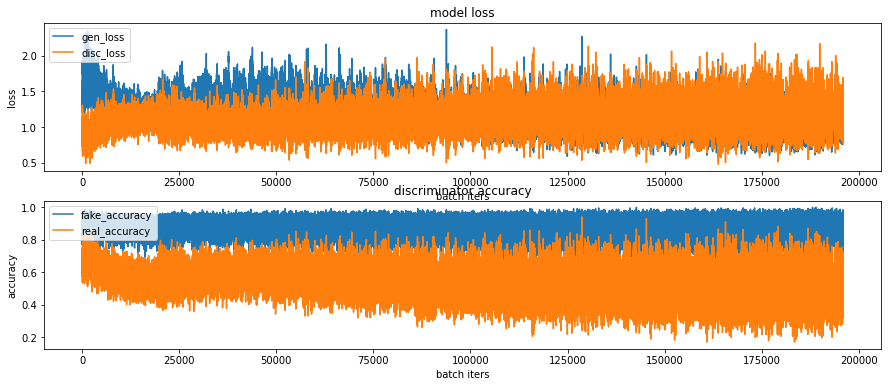

CPU times: user 5h 21min 45s, sys: 23min 30s, total: 5h 45min 15s
Wall time: 5h 12min 1s


In [91]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [92]:
#시각화
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1034187 Feb 14 06:52 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


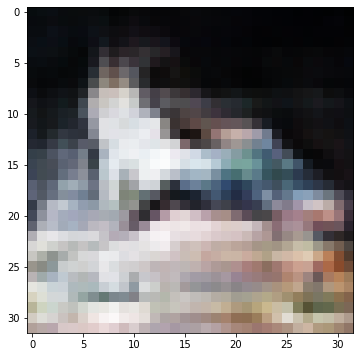

In [93]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## EXPLORATION 10 회고  
  
#### (1) EPOCH = 50   
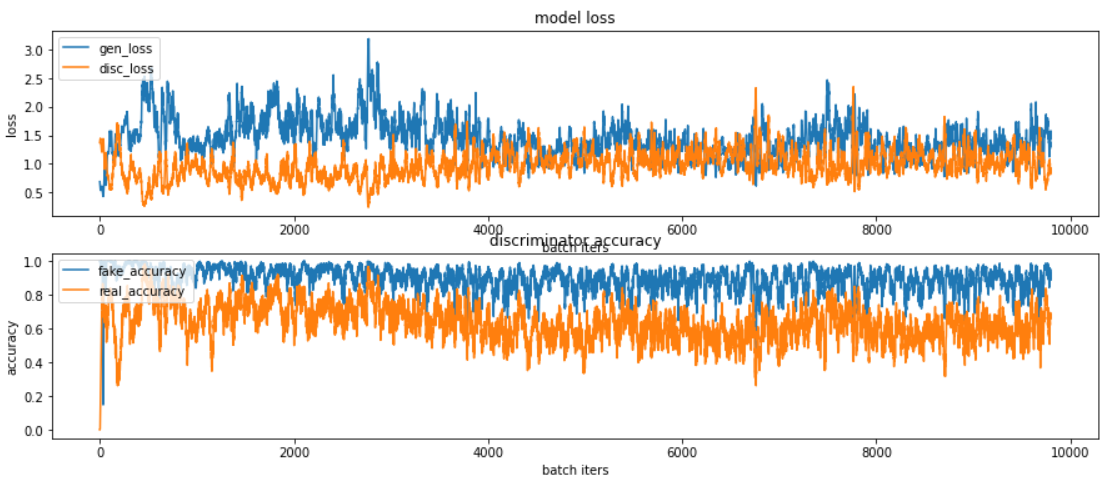
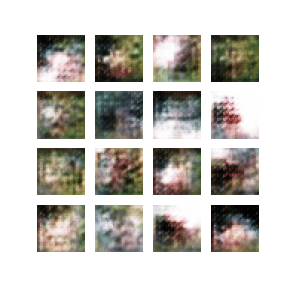
어떤 그림인지 불분명하고, 배경과 피사체 조차 분리되지 않는 흐릿한 화질이다.    
  
#### (2) EPOCH = 200  

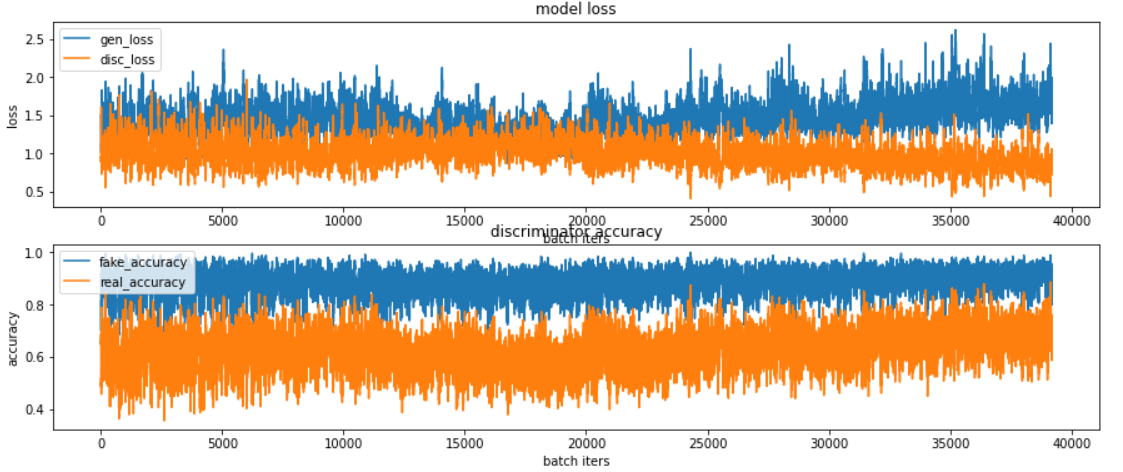
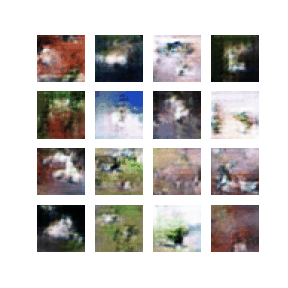

epoch 50보다는 개선되었고, 배경과 피사체는 색깔로 어느정도 구분이 되지만 아직도 화질이 많이 낮아 무슨 사진인지 구분이 잘 안되는 결과를 도출했다.  
  
#### (3) EPOCH = 1000  
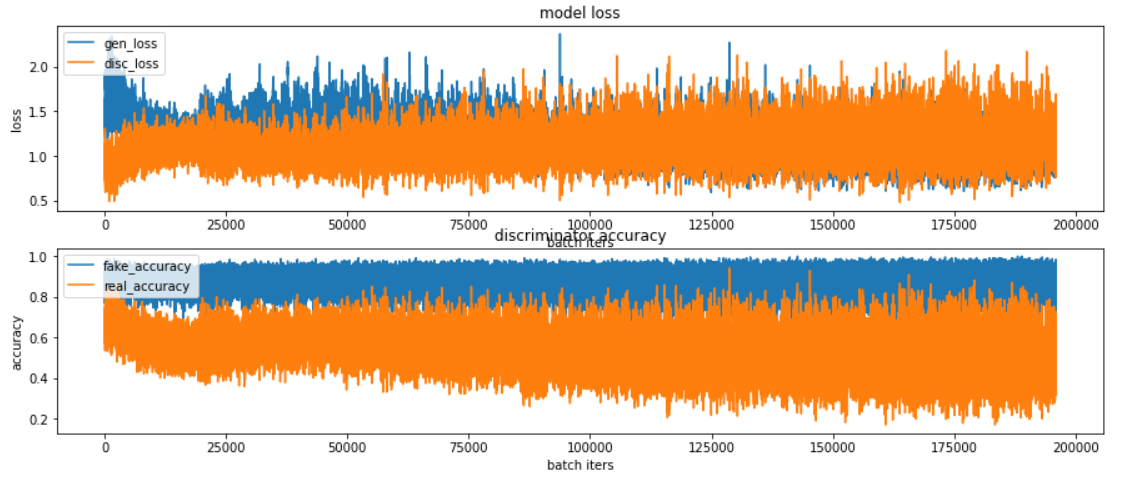  
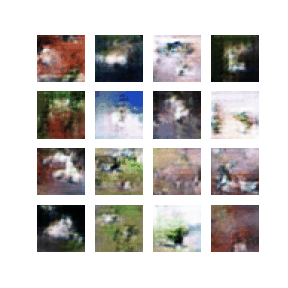
EPOCH만 조정했는데도 처음과 비교하면 엄청나게 좋은 결과를 얻어냈다. 다만 아직도 화질이 흐리지만 흐릿하게라도 그림의 형체가 보인다.  
  
   
   
batch_size를 514로 높이니 결과가 급격하게 좋지 않아져서 실습 그대로인 256으로 유지했다.  
tf.keras.optimizers.Adam(1e-4) 또한 2e-4로 조정해봤는데, 생각보다 미미한 변화와 결과가 이전보다 좋지 않아져서 1e-4로 유지했다.  
epoch를 올리면 올릴수록 이미지 화질이 많이 개선될 것이라고 예상했는데, 물론 처음보다는 나아졌지만 아직도 화질이 많이 개선되지 않은 결과를 내어 아쉽다. epoch는 높으면 높을수록 화질이 개선될 것 같고 1만 이상으로 하면 지금보다 훨씬 많이 개선될 것 같다.   
이번 프로젝트는 스스로 코드를 작성해야하는 것 보다는 프로젝트를 이해하고 데이터 값을 변경하며 진행해야 했는데, GAN을 처음 접해봐서 이론적인 이해도가 낮아 어려웠다. 모델 학습이 정말 오래걸렸는데 안 튕겨준 컴퓨터에게 너무 고마울 따름..^^  
  
  
---
2022-02-15